In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import Dependancies
import pandas as pd
import numpy as np
from path import Path
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

## Preprocessing the Data

In [3]:
# Read the CSV into Pandas
file_path = ('Resources/crypto_data.csv')
crypto_df = pd.read_csv(file_path)
crypto_df = crypto_df.set_index('Unnamed: 0')

crypto_df.index.name = None
print(crypto_df.shape)
crypto_df

(1252, 6)


,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
42,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
365,365Coin,X11,True,PoW/PoS,NaN,2300000000
404,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
611,SixEleven,SHA-256,True,PoW,NaN,611000
808,808,SHA-256,True,PoW/PoS,0.000000e+00,0
...,...,...,...,...,...,...
XBC,BitcoinPlus,Scrypt,True,PoS,1.283270e+05,1000000
DVTC,DivotyCoin,Scrypt,False,PoW/PoS,2.149121e+07,100000000
GIOT,Giotto Coin,Scrypt,False,PoW/PoS,NaN,233100000
OPSC,OpenSourceCoin,SHA-256,False,PoW/PoS,NaN,21000000


In [4]:
# Discard the cryptocurrencies not being traded
crypto_df = crypto_df.loc[crypto_df["IsTrading"] == True]
print(crypto_df.shape)

crypto_df.head(10)

(1144, 6)


,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
42,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
365,365Coin,X11,True,PoW/PoS,NaN,2300000000
404,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
611,SixEleven,SHA-256,True,PoW,NaN,611000
808,808,SHA-256,True,PoW/PoS,0.000000e+00,0
1337,EliteCoin,X13,True,PoW/PoS,2.927942e+10,314159265359
2015,2015 coin,X11,True,PoW/PoS,NaN,0
BTC,Bitcoin,SHA-256,True,PoW,1.792718e+07,21000000
ETH,Ethereum,Ethash,True,PoW,1.076842e+08,0
LTC,Litecoin,Scrypt,True,PoW,6.303924e+07,84000000


In [5]:
# Keep cryptocurrencies that have a working algorithm
crypto_df = crypto_df.dropna(subset = ["Algorithm"])
print(crypto_df.shape)
crypto_df.head(10)

(1144, 6)


,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
42,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
365,365Coin,X11,True,PoW/PoS,NaN,2300000000
404,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
611,SixEleven,SHA-256,True,PoW,NaN,611000
808,808,SHA-256,True,PoW/PoS,0.000000e+00,0
1337,EliteCoin,X13,True,PoW/PoS,2.927942e+10,314159265359
2015,2015 coin,X11,True,PoW/PoS,NaN,0
BTC,Bitcoin,SHA-256,True,PoW,1.792718e+07,21000000
ETH,Ethereum,Ethash,True,PoW,1.076842e+08,0
LTC,Litecoin,Scrypt,True,PoW,6.303924e+07,84000000


In [6]:
# Drop the IsTrading column from the dataframe
crypto_df = crypto_df.drop(columns = "IsTrading")
print(crypto_df.shape)
crypto_df

(1144, 5)


,CoinName,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
42,42 Coin,Scrypt,PoW/PoS,4.199995e+01,42
365,365Coin,X11,PoW/PoS,NaN,2300000000
404,404Coin,Scrypt,PoW/PoS,1.055185e+09,532000000
611,SixEleven,SHA-256,PoW,NaN,611000
808,808,SHA-256,PoW/PoS,0.000000e+00,0
...,...,...,...,...,...
SERO,Super Zero,Ethash,PoW,NaN,1000000000
UOS,UOS,SHA-256,DPoI,NaN,1000000000
BDX,Beldex,CryptoNight,PoW,9.802226e+08,1400222610
ZEN,Horizen,Equihash,PoW,7.296538e+06,21000000


In [7]:
# Remove all rows that have at least one null value
crypto_df = crypto_df.dropna()
print(crypto_df.shape)
crypto_df.head(10)

(685, 5)


,CoinName,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
42,42 Coin,Scrypt,PoW/PoS,4.199995e+01,42
404,404Coin,Scrypt,PoW/PoS,1.055185e+09,532000000
808,808,SHA-256,PoW/PoS,0.000000e+00,0
1337,EliteCoin,X13,PoW/PoS,2.927942e+10,314159265359
BTC,Bitcoin,SHA-256,PoW,1.792718e+07,21000000
ETH,Ethereum,Ethash,PoW,1.076842e+08,0
LTC,Litecoin,Scrypt,PoW,6.303924e+07,84000000
DASH,Dash,X11,PoW/PoS,9.031294e+06,22000000
XMR,Monero,CryptoNight-V7,PoW,1.720114e+07,0
ETC,Ethereum Classic,Ethash,PoW,1.133597e+08,210000000


In [8]:
# Filter for cryptocurrencies that have been mined (greater than Zero)
crypto_df = crypto_df.loc[crypto_df["TotalCoinsMined"] > 0]
print(crypto_df.shape)
crypto_df.head(10)

(532, 5)


,CoinName,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
42,42 Coin,Scrypt,PoW/PoS,4.199995e+01,42
404,404Coin,Scrypt,PoW/PoS,1.055185e+09,532000000
1337,EliteCoin,X13,PoW/PoS,2.927942e+10,314159265359
BTC,Bitcoin,SHA-256,PoW,1.792718e+07,21000000
ETH,Ethereum,Ethash,PoW,1.076842e+08,0
LTC,Litecoin,Scrypt,PoW,6.303924e+07,84000000
DASH,Dash,X11,PoW/PoS,9.031294e+06,22000000
XMR,Monero,CryptoNight-V7,PoW,1.720114e+07,0
ETC,Ethereum Classic,Ethash,PoW,1.133597e+08,210000000
ZEC,ZCash,Equihash,PoW,7.383056e+06,21000000


In [9]:
# Create a new DataFrame that only holds the cryptocurrency names
crypto_name_df = pd.DataFrame(crypto_df["CoinName"])
print(crypto_name_df.shape)
crypto_name_df.head()

(532, 1)


,CoinName
42,42 Coin
404,404Coin
1337,EliteCoin
BTC,Bitcoin
ETH,Ethereum


In [10]:
# Delete "CoinName" from the original DataFrame since it does not contribute to the analysis
crypto_df = crypto_df.drop(columns = "CoinName")
print(crypto_df.shape)
crypto_df.head(10)

(532, 4)


,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
42,Scrypt,PoW/PoS,4.199995e+01,42
404,Scrypt,PoW/PoS,1.055185e+09,532000000
1337,X13,PoW/PoS,2.927942e+10,314159265359
BTC,SHA-256,PoW,1.792718e+07,21000000
ETH,Ethash,PoW,1.076842e+08,0
LTC,Scrypt,PoW,6.303924e+07,84000000
DASH,X11,PoW/PoS,9.031294e+06,22000000
XMR,CryptoNight-V7,PoW,1.720114e+07,0
ETC,Ethash,PoW,1.133597e+08,210000000
ZEC,Equihash,PoW,7.383056e+06,21000000


In [11]:
# Convert remaining text variables into numerical data using get_dummies
X = pd.get_dummies(crypto_df, columns=["Algorithm","ProofType"])

print(X.shape)
X

(532, 98)


,TotalCoinsMined,TotalCoinSupply,Algorithm_1GB AES Pattern Search,Algorithm_536,Algorithm_Argon2d,Algorithm_BLAKE256,Algorithm_Blake,Algorithm_Blake2S,Algorithm_Blake2b,Algorithm_C11,...,ProofType_PoW/PoS,ProofType_PoW/PoS,ProofType_PoW/PoW,ProofType_PoW/nPoS,ProofType_Pos,ProofType_Proof of Authority,ProofType_Proof of Trust,ProofType_TPoS,ProofType_Zero-Knowledge Proof,ProofType_dPoW/PoW
42,4.199995e+01,42,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
404,1.055185e+09,532000000,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1337,2.927942e+10,314159265359,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
BTC,1.792718e+07,21000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ETH,1.076842e+08,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZEPH,2.000000e+09,2000000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GAP,1.493105e+07,250000000,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
BDX,9.802226e+08,1400222610,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ZEN,7.296538e+06,21000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Examining the Number of Rows & Columns in the dataset, the original dataset held 532 Rows & 4 Columns.  When turning the dataset into Numerical Values, the new dataset now holds the same 532 Rows but jumped to 98 Columns.


In [12]:
# Standardize the dataset
scaler = StandardScaler()
crypto_scaled = scaler.fit_transform(X)
crypto_scaled[0:5]

array([[-0.11710817, -0.1528703 , -0.0433963 , -0.0433963 , -0.0433963 ,
        -0.06142951, -0.07530656, -0.0433963 , -0.06142951, -0.06142951,
        -0.0433963 , -0.0433963 , -0.19245009, -0.06142951, -0.09740465,
        -0.0433963 , -0.11547005, -0.07530656, -0.0433963 , -0.0433963 ,
        -0.15191091, -0.0433963 , -0.13118084, -0.0433963 , -0.0433963 ,
        -0.08703883, -0.0433963 , -0.0433963 , -0.0433963 , -0.0433963 ,
        -0.06142951, -0.0433963 , -0.08703883, -0.08703883, -0.08703883,
        -0.0433963 , -0.13118084, -0.13840913, -0.13840913, -0.0433963 ,
        -0.06142951, -0.0433963 , -0.07530656, -0.18168574, -0.0433963 ,
        -0.0433963 , -0.0433963 , -0.07530656, -0.15826614, -0.31491833,
        -0.0433963 , -0.08703883, -0.07530656, -0.06142951,  1.38675049,
        -0.0433963 , -0.0433963 , -0.06142951, -0.0433963 , -0.0433963 ,
        -0.0433963 , -0.0433963 , -0.0433963 , -0.0433963 , -0.0433963 ,
        -0.0433963 , -0.39879994, -0.0433963 , -0.1

# Dimentionality Reduction

In [13]:
# Perform dimensionality with PCA
pca = PCA(n_components=0.90)

crypto_pca = pca.fit_transform(crypto_scaled)

crypto_pca.shape

(532, 74)

#### How did the number of features change? 
Inputting n-components as 0.90 (90%), the columns went from 98 to 74.

#### Further Reduce the dataset dimensions using t-sne

In [14]:
from sklearn.manifold import TSNE

# Initialize t-SNE model
tsne = TSNE()

In [15]:
type(crypto_pca)

numpy.ndarray

In [16]:
# Create a DataFrame for t-sne with the Principal Components
crypto_pca_df = pd.DataFrame(crypto_pca)

crypto_pca_df.head()

,0,1,2,3,4,5,6,7,8,9,...,64,65,66,67,68,69,70,71,72,73
0,-0.335099,1.032189,-0.590713,0.001397,-1.540297e-14,-1.165476e-11,1.934877e-14,-0.007129,-1.319756,-0.051813,...,6.791870e-16,3.244575e-16,-1.011010e-15,-2.982695e-15,-1.731974e-15,5.284002e-15,-1.924284e-15,3.781938e-15,-4.015154e-16,2.426681e-16
1,-0.318434,1.032331,-0.591126,0.001386,-1.523083e-14,-1.155975e-11,1.954039e-14,-0.007739,-1.322514,-0.056674,...,-4.586593e-16,9.072591e-16,-2.269850e-15,-2.263852e-15,-2.660612e-15,7.651009e-15,-1.525656e-15,3.355866e-15,-5.762231e-16,5.071767e-18
2,2.305468,1.656383,-0.683617,0.004731,-1.497294e-14,-3.949449e-11,3.772165e-14,-0.054781,-1.542879,-0.943951,...,1.780031e-14,-4.989842e-14,4.825798e-14,3.187038e-14,3.098898e-14,-9.932864e-14,-3.553773e-14,-7.367435e-14,3.182511e-14,-1.967865e-14
3,-0.145184,-1.320593,0.192813,-0.001229,3.693199e-15,1.025361e-11,-8.871203e-15,-0.002071,0.281463,0.251862,...,1.280944e-15,-1.279970e-15,8.288230e-15,2.691578e-15,-4.122980e-15,-1.425553e-14,-3.198069e-15,-1.367220e-14,6.083623e-15,-1.688258e-14
4,-0.151768,-2.036192,0.396182,-0.001705,1.570991e-14,1.423168e-11,-1.220895e-14,0.027735,0.519099,0.188820,...,-6.092554e-16,1.358936e-14,7.275832e-14,-8.776375e-14,-7.938475e-14,-6.460819e-14,3.930429e-14,-7.474587e-14,1.316774e-13,-2.987009e-13


In [17]:
# Reduce the Number of Dimensions
tsne_features = tsne.fit_transform(crypto_pca_df)
tsne_features.shape

(532, 2)

In [18]:
tsne_features

array([[ -6.341101 , -15.33956  ],
       [ -9.027109 , -22.131239 ],
       [ -7.8923087, -30.224684 ],
       ...,
       [ 19.826832 ,  -6.239761 ],
       [ 19.657093 ,   4.545205 ],
       [ -6.58588  ,   9.810639 ]], dtype=float32)

In [19]:
# Create the tsne DataFrame
tsne_features_df = pd.DataFrame(tsne_features)
tsne_features_df

,0,1
0,-6.341101,-15.339560
1,-9.027109,-22.131239
2,-7.892309,-30.224684
3,0.761763,35.107922
4,15.758497,11.494983
...,...,...
527,2.622423,29.441559
528,-5.828704,-21.655022
529,19.826832,-6.239761
530,19.657093,4.545205


In [20]:
# Create a Scatter Plot of the tsne dataset

# The first column of transformed features
crypto_pca_df['x'] = tsne_features[:,0]

# The second column of transformed features
crypto_pca_df['y'] = tsne_features[:,1]

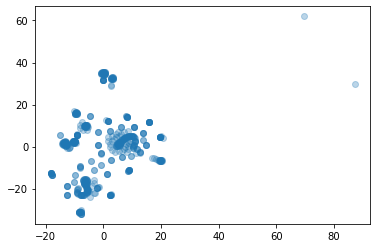

In [21]:
plt.scatter(crypto_pca_df['x'], crypto_pca_df['y'], alpha=0.3)
plt.show()

#### Are there Distict Clusters that we can observe from the t-SNE Scatterplot?
From my observation, there appears to be 3 distict clusters with a possibility of 4. 

# Cluster Analysis with K-Means

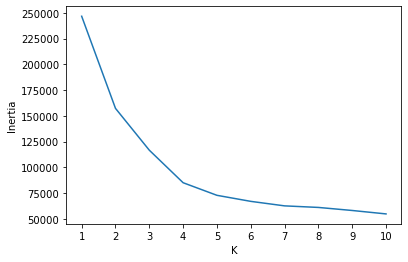

In [22]:
# Create an Elbow Curve to find the best value for K
inertia = []

k = list(range(1,11))
for i in k:
    km = KMeans(n_clusters = i, random_state = 42)
    km.fit(crypto_pca_df)
    inertia.append(km.inertia_)
    
    
elbow_data = {"k": k, "inertia" : inertia}
elbow_df = pd.DataFrame(elbow_data)


plt.plot(elbow_df['k'], elbow_df['inertia'])
plt.xticks(range(1,11))
plt.xlabel('K')
plt.ylabel('Inertia')
plt.show()

### Observation:
Elbow Curve showing at k-4 which means that there are 4 prominent clusters.

### Recommendation:
Based on the above Elbow plot, we can see that the curve starts to level out (plateau) at K-4 giving us the assumption that there are in fact 4 prominent clusters.  The Scatter Plot is also in line with this assumption showing 4 clusters.  However, I also see a very small bend at k-5 so one would have to work off clustering with 4 as well as 5 to make an acurate analysis.  We might be able to see this a bit better with a 3-D Scatter plot rather than a 2-D.  I would recommend a little bit more analysis will need to go into this but the cryptocurrency can be clustered togehter, it will just depend on if there will be 4 or 5 clusters to group together.